# Visual insights into Passwords


## Introduction 
Today, password is the most common authentication scheme due ease of development and usage. Unfortunately, users tend to choose predictable passwords because they are easier to remember. Passwords such as *123456* or *password* are very common. 

To combat this, password policy usually has requirements on password length, mixed case rules, use of digits, and use of special characters. However, despite all this, users are still able to get around the system using something like *P@ssw0rd*. 

## Goal
In this notebook, I will explore a dataset of passwords to identify common occurences. The main goal is to provide a method of visualization on commonly chosen password topics. 

## Part 1: Dataset Exploration
### Importing data

In [77]:
# import the necessary modules
import pandas as pd 
import numpy as np
from gensim.models import fasttext
import matplotlib.pyplot as plt
import seaborn as sns
import PyQt5
import umap

# from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from zxcvbn import zxcvbn

In [2]:
# Loading the data into a pandas dataframe
df = pd.read_csv('../data/dataset/USA1.csv')
df.head(10)

,password,frequency,distance_score,passlength,unique_c,first_char,last_char,number_of_uppercase,number_of_digits,number_of_symbols
0,123456,58393,1.00,6,6,digit,digit,0,6,0
1,q1w2e3r4t5y6,51029,1.23,12,12,lower,digit,0,6,0
2,1qaz2wsx3edc,33725,1.59,12,12,digit,lower,0,3,0
3,1q2w3e4r5t,27305,1.78,10,10,digit,lower,0,5,0
4,123456789,17213,1.00,9,9,digit,digit,0,9,0
5,!~!1,14362,0.67,4,3,symbol,digit,0,1,3
6,q1w2e3r4,9976,1.24,8,8,lower,digit,0,4,0
7,12345,7232,1.00,5,5,digit,digit,0,5,0
8,12345678,6924,1.00,8,8,digit,digit,0,8,0
9,q1w2e3r4t5,6435,1.23,10,10,lower,digit,0,5,0


In [3]:
# description of the dataframe
df.info(verbose=True,null_counts=True)

<ipython-input-3-9dca9f5396c8>:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(verbose=True,null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9522181 entries, 0 to 9522180
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   password             9522176 non-null  object 
 1   frequency            9522181 non-null  int64  
 2   distance_score       9521779 non-null  float64
 3   passlength           9522181 non-null  int64  
 4   unique_c             9522181 non-null  int64  
 5   first_char           9522181 non-null  object 
 6   last_char            9522181 non-null  object 
 7   number_of_uppercase  9522181 non-null  int64  
 8   number_of_digits     9522181 non-null  int64  
 9   number_of_symbols    9522181 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 726.5+ MB


As we can see, we have a list of passwords ordered in descending order according to frequency. Note that this dataset has been processed from a larger list of password data. Here is a brief explanation for each column.

- `password`: passwords that occur in the dataset.
- `frequency`: occurence of each password in the password data,
- `distance_score`: average the successive keyboard distances from one character to the next,
- `passlength`: password length,
- `unique_c`: number of distinct characters in the password,
- `first_char`: type of the first chracter  in the password (lower case, upper case, digit, or special).
- `last_char`: type of  the last character in the password (lower case, upper case, digit, or special)
- `number_of_uppercase`: number of uppercase letter in the 
- `number_of_digits`: number of digits in the password,
- `number_of_symbols`: number of special characters in the password.

### Some processing

In [4]:
# dropping rows that have null entries
df.dropna(inplace=True)

In [5]:
# counting of passwords with length > 40
df[df.passlength > 40].shape[0]

656

In [6]:
# since the above the number of password is relatively negligible, we remove them
df = df[df.passlength <= 40]

In [7]:
df

,password,frequency,distance_score,passlength,unique_c,first_char,last_char,number_of_uppercase,number_of_digits,number_of_symbols
0,123456,58393,1.00,6,6,digit,digit,0,6,0
1,q1w2e3r4t5y6,51029,1.23,12,12,lower,digit,0,6,0
2,1qaz2wsx3edc,33725,1.59,12,12,digit,lower,0,3,0
3,1q2w3e4r5t,27305,1.78,10,10,digit,lower,0,5,0
4,123456789,17213,1.00,9,9,digit,digit,0,9,0
...,...,...,...,...,...,...,...,...,...,...
9522176,mixer197311,1,3.00,11,9,lower,digit,0,6,0
9522177,Kristi12,1,3.92,8,7,upper,digit,1,2,0
9522178,epson0,1,6.31,6,6,lower,digit,0,1,0
9522179,g9Tn3jhz5J,1,3.79,10,10,lower,upper,2,3,0


To facilitate the processing, we will divide the dataset into 10 pieces. For the present, we shall only work with the first 1 million rows. We will also add the the column `number_of_lowercase`.

In [10]:
dfL = []
for i in range(10):
    if i<9:
        dfL.append(df.iloc[i*1000000:(i+1)*1000000, :])
    else:
        dfL.append(df.iloc[9000000: , :])

In [15]:
import string
def num_lower(row):
    lower_alphabet = string.ascii_lowercase
    row['number_of_lowercase'] = 0
    for char in row['password']:
        if char in lower_alphabet:
            row['number_of_lowercase'] += 1
    return row

In [46]:
dfL[0] = dfL[0].apply(num_lower, axis=1)

In [52]:
# for ease of use
dff = dfL[0]

In [54]:
dff.to_csv('../data/data2use/data0.csv')

### Characters distribution

In [55]:
# obtain possible characters in dff together with the number of occurences.
characters = {}
for index, row in dff.iterrows():
    for char in row['password']:
        if char in characters:
            characters[char] += 1
        else:
            characters[char] = 1

In [56]:
len(characters), characters.keys()

(122,
 dict_keys(['1', '2', '3', '4', '5', '6', 'q', 'w', 'e', 'r', 't', 'y', 'a', 'z', 's', 'x', 'd', 'c', '7', '8', '9', '!', '~', 'p', 'o', 'm', 'n', 'P', 'h', 'f', 'i', 'D', 'l', 'v', 'u', '0', 'b', 'k', 'j', 'g', 'V', 'H', 'J', 'R', 'Z', 'A', 'S', 'M', 'E', 'I', 'F', 'Q', 'G', 'C', 'W', 'O', 'X', 'B', 'L', '_', 'T', 'Y', 'K', '`', 'N', '@', 'U', '.', ' ', '$', '?', '#', ',', '/', '*', '+', ';', "'", '-', '^', '}', '"', '&', '=', '%', '(', ')', '{', ':', '\\', '<', 'Ð', '\x93', 'Â', '°', '\x92', 'Ñ', '\x9b', 'Ò', '\x91', '\x8e', '¤', '>', '±', '§', '¿', '\x97', '\x85', '\xa0', 'â', '\x80', '\x9c', '\x13', '\x05', '\x15', '\x99', '¡', '\x94', '²', '\x82', '\x9d', '¦']))

We detect 122 different characters. Most of the characters are the usual digits and latin alphabets. However, there are instances of symbols, special printable and nonprintable ascii characters. 

In [57]:
cframe = pd.DataFrame.from_dict(characters, orient='index',columns=['count'])
cframe.sort_values(by='count', ascending=False, inplace=True)
cframe.head(20)

,count
a,729154
e,556512
1,531611
i,433536
r,415346
n,411288
o,393429
s,374190
0,344632
l,329387


In [58]:
# the tail end of the frame, note that some characters are not printable
cframe.tail(20)

,count
,2
,2
°,2
¤,1
,1
,1
,1
,1
¡,1
,1


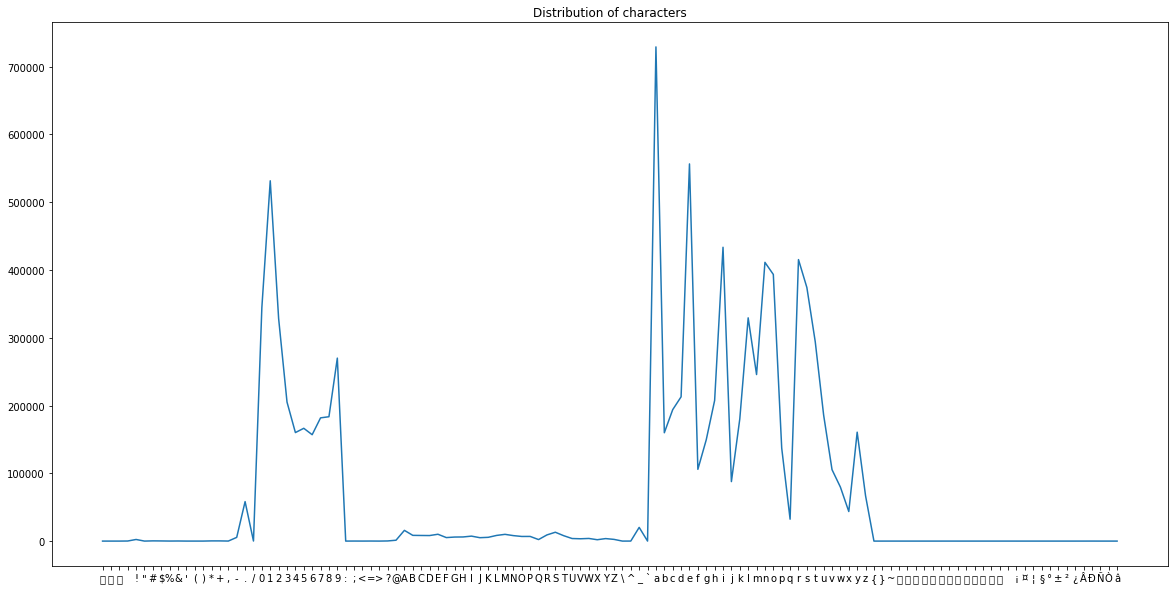

In [60]:
# visualize the distribution
plt.figure(figsize=(20,10))
plt.plot(cframe.sort_index())
plt.title('Distribution of characters')
plt.show()

As expected, we see that the vast majority of the passwords use digits and lowercase letters. Note that this distribution does not keep track of the frequency of a specific password. It is also important to keep in mind that there are various contributing factors at play. For example:
- keyboard layout bias, e.g., various versions of *qwerty*, *asdfgh*, or *123456*.
- topic bias, e.g., various version of *password*.
- language letter frequency. For example, in the Concise Oxford English dictionary, the letter *e* is the most frequent, appearing in about 11.1% the words, while the letter *a* ranks second at about 8.5%. Interestingly, we can see some semblance of that in our counts. 

### Some password categories
Using these information, for the sake of visualization, we will place these passwords into the following categories: 
- `numeric`: >=80% of the characters are digits.
- `alphabetic`: >=80% of the characters are letters.
- `mixed`: >=30% of the characers are numbers, >=30% are digits, excluding passwords that are `numeric` or `alphabetic`.
- `others`: the remaining passwords, these could be passwords consisting of mostly special characters. 

In [72]:
# filtering function on dataframe
p = 0.8
q = 0.3
def categories(row):
    number_ratio = row['number_of_digits']/row['passlength']
    letter_ratio = (row['number_of_uppercase']+row['number_of_lowercase'])/row['passlength']
    
    if  number_ratio >= p:
        row['category'] = 'numeric'
    elif letter_ratio >= p:
        row['category'] = 'alphabetic'
    elif number_ratio >= q and letter_ratio >= q:
        row['category'] = 'mixed'
    else:
        row['category'] = 'others'
    return row

In [73]:
dff = dff.apply(categories, axis=1)

In [76]:
dff.head()

,password,frequency,distance_score,passlength,unique_c,first_char,last_char,number_of_uppercase,number_of_digits,number_of_symbols,number_of_lowercase,category
0,123456,58393,1.00,6,6,digit,digit,0,6,0,0,numeric
1,q1w2e3r4t5y6,51029,1.23,12,12,lower,digit,0,6,0,6,mixed
2,1qaz2wsx3edc,33725,1.59,12,12,digit,lower,0,3,0,9,others
3,1q2w3e4r5t,27305,1.78,10,10,digit,lower,0,5,0,5,mixed
4,123456789,17213,1.00,9,9,digit,digit,0,9,0,0,numeric


### Charts
Let us proceed with some visualization.

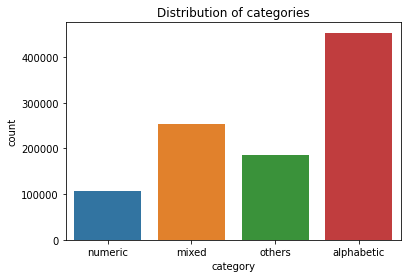

In [87]:
# Distribution of categories
sns.countplot(x='category', data=dff)
plt.title('Distribution of categories')
plt.show()

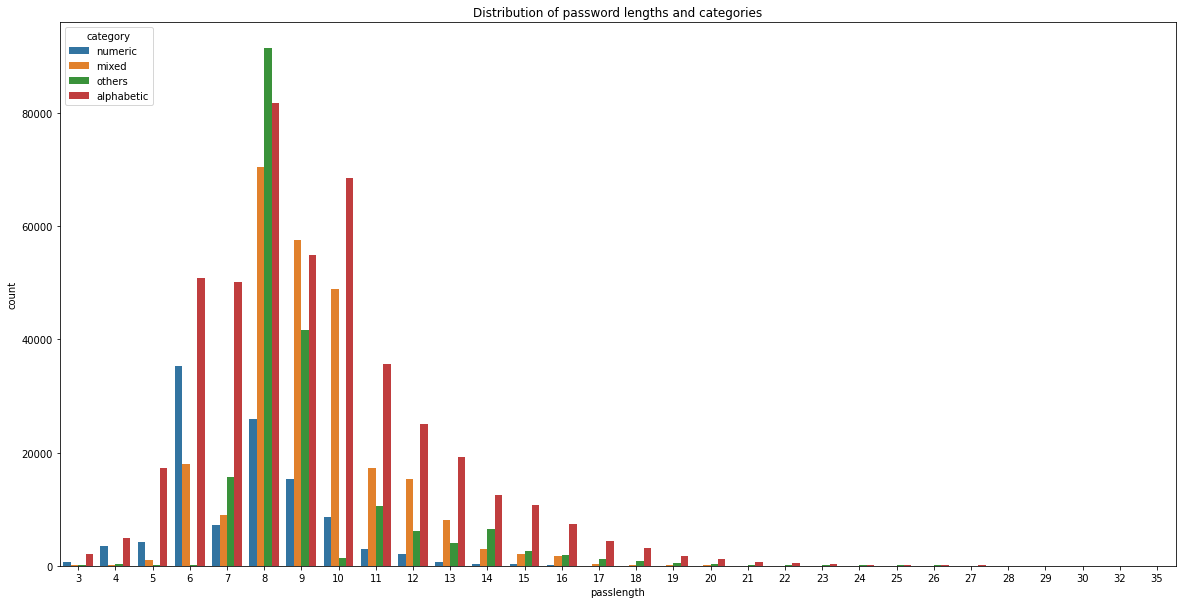

In [84]:
# Let us add in password length into the picture
plt.figure(figsize=(20,10))
sns.countplot(x='passlength', data=dff, hue='category')
plt.title('Distribution of password lengths and categories')
plt.show()